# Binary Image Classification using VGG16 and Custom Model


1.   Data Augmentation
2.   Transfer Learning
3.   Grad-CAM





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/chest_xray.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: ches

Import Libraries

In [3]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import os, random
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


Import data

In [41]:
# def getFiles(train, path):
#     images = []
#     count = 0
#     for folder in os.listdir(path):
#         for file in  os.listdir(os.path.join(path, folder)):
#             images.append(os.path.join(path, os.path.join(folder, file)))

#     if(train is True):
#         np.random.shuffle(images)
    
#     return images
    

# def readImage(img_path):
#     img = cv2.imread(img_path, 0)
#     return cv2.resize(img,(150,150))

# def get_pathframe(path):
#   '''
#   Get all the images paths and its corresponding labels
#   Store them in pandas dataframe
#   '''
#   class_index = []
#   images = getFiles(True, path)

#   for img_path in images:
#         # print(img_path)
#         category = img_path.split('/')[3]
#         # print(category)
#         if category == 'normal':
#             class_index.append(0)
#         else:
#             class_index.append(1)

#         img = readImage(img_path)
#   df= pd.DataFrame({
#       'filename': images,
#       'category': class_index,
#   })
#   return df

In [42]:
# df_train=get_pathframe("/content/train/")
# df_train.tail(5)

In [43]:
# df_test=get_pathframe("/content/test/")
# df_test.tail(5)

delete extra class of 'ipynb_checkpoints' using shutil to maintain 2 classes instead of 3

In [44]:
# import shutil

# os.listdir("/content/train/")
# # shutil.rmtree("/content/train/.ipynb_checkpoints")
# # shutil.rmtree("/content/test/.ipynb_checkpoints")
# os.listdir("/content/train/")
# os.listdir("/content/test/")

 Split into Train and Validation

In [45]:
# msk = np.random.rand(len(df_train)) < 0.8
# train = df_train[msk]
# val = df_train[~msk]

# #training data and label
# X_train=train.iloc[:,0]
# Y_train=train.iloc[:,1]

# #validation data and label
# X_val=val.iloc[:,0]
# Y_val=val.iloc[:,1]

# #test data and label
# X_test=df_test.iloc[:,0]
# Y_test=df_test.iloc[:,1]

# DATA AUGMENTATION
ZOOM, ROTATE, HORIZONTAL FLIP, BRIGHTNESS

In [4]:
# Data Preprocessing and Augmentation
# Generate training, testing and validation batches
dgen_train = ImageDataGenerator(rescale=1./255,
                                validation_split=0.2,  # using 20% of training data for validation 
                                zoom_range=0.2,
                                rotation_range=15,
                                horizontal_flip=True,
                                brightness_range=[0.1, 2])
dgen_validation = ImageDataGenerator(rescale=1./255)
dgen_test = ImageDataGenerator(rescale=1./255)


In [5]:
TARGET_SIZE = (150, 150)
BATCH_SIZE = 32
CLASS_MODE = 'binary'  # for two classes; categorical for over 2 classes

# Connecting the ImageDataGenerator objects to our dataset
train_generator = dgen_train.flow_from_directory('/content/chest_xray/train/',
                                                 target_size=TARGET_SIZE,
                                                 subset='training',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE)
print(train_generator)
validation_generator = dgen_train.flow_from_directory('/content/chest_xray/train/',
                                                      target_size=TARGET_SIZE,
                                                      subset='validation',
                                                      batch_size=BATCH_SIZE,
                                                      class_mode=CLASS_MODE)
test_generator = dgen_test.flow_from_directory('/content/chest_xray/test/',
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode=CLASS_MODE)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [7]:
train_generator.image_shape

(150, 150, 3)

# VGG16

In [8]:
model = VGG16(include_top=False, input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [9]:
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(1, activation='sigmoid')(class1) # add softmax layer

In [10]:
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Training VGG16

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [12]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', 
              optimizer=adam,
              metrics=['accuracy'])

In [14]:
import time
start_time = time.time()
H = model.fit(train_generator, batch_size=128,
              epochs=5, 
              validation_data=validation_generator)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/5
131/131 [==============================] - 117s 892ms/step - loss: 0.6170 - accuracy: 0.7411 - val_loss: 0.5729 - val_accuracy: 0.7426
Epoch 2/5
131/131 [==============================] - 106s 812ms/step - loss: 0.5764 - accuracy: 0.7421 - val_loss: 0.5705 - val_accuracy: 0.7426
Epoch 3/5
131/131 [==============================] - 107s 816ms/step - loss: 0.5711 - accuracy: 0.7421 - val_loss: 0.5705 - val_accuracy: 0.7426
Epoch 4/5
131/131 [==============================] - 108s 819ms/step - loss: 0.5714 - accuracy: 0.7421 - val_loss: 0.5707 - val_accuracy: 0.7426
Epoch 5/5
131/131 [==============================] - 107s 817ms/step - loss: 0.5713 - accuracy: 0.7421 - val_loss: 0.5706 - val_accuracy: 0.7426
--- 615.6727876663208 seconds ---


Testing VGG16

In [15]:
score = model.evaluate(test_generator)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

20/20 [==============================] - 9s 467ms/step - loss: 0.7012 - accuracy: 0.6250
Test Loss =  0.7012247443199158
Test Accuracy =  0.625


In [16]:
# import numpy as np
# import sklearn.metrics as metrics
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# # test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
# # predictions = model.predict(test_generator, steps=test_steps_per_epoch)

# pred = model.predict(test_generator, steps=1)

# # Get most likely class
# predicted_classes = np.argmax(pred[0])

# # true_classes = test_generator.classes
# # class_labels = list(test_generator.class_indices.keys())  
# # print(predictions[0][0])
# print(predicted_classes)

In [17]:
# print(decode_predictions(pred)[0])

In [18]:
# save the model to disk
import joblib
filename = 'finalized_model.sav'
joblib.dump(model, filename)

INFO:tensorflow:Assets written to: ram://74e07c93-f28a-415a-a621-10957abb7811/assets


['finalized_model.sav']

Training and Validation Accuracy for VGG16

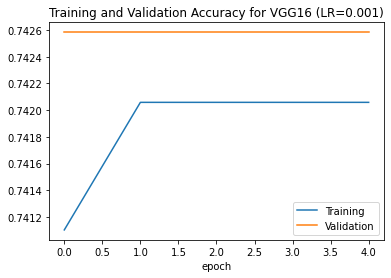

In [19]:
acc=H.history['accuracy']
val_acc=H.history['val_accuracy']
loss=H.history['loss']
val_loss=H.history['val_loss']
 
epochs=range(len(acc)) 
 
#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Accuracy for VGG16 (LR=0.001)')
plt.xlabel('epoch')
plt.savefig("Training and Validation Accuracy (VGG16, LR =0.001) Chest.svg")

Training and Validation Loss for VGG16

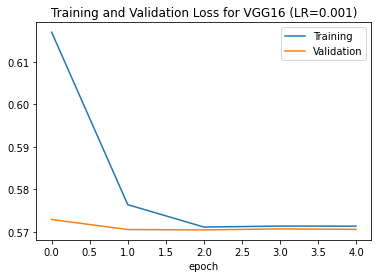

In [20]:
# Plot graph between training and validation loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Loss for VGG16 (LR=0.001)')
plt.xlabel('epoch')
plt.savefig("Training and Validation Loss (VGG16, LR =0.001) Chest .svg")

Display Prediction


Original Class: 0 - Normal
Predicted Class: 1 - Pneumonia


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


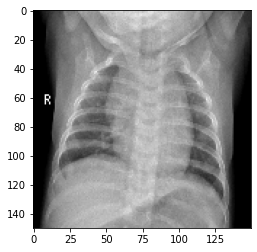

In [27]:
from keras.preprocessing import image
img = image.load_img("/content/chest_xray/train/NORMAL/IM-0608-0001-0001.jpeg",target_size=(150,150))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
print("Original Class: 0 - Normal")
output = model.predict(img)
x=np.argmax(output, axis=1 )
if x=="0":
    print("Predicted Class: 0 - normal")
else:
    print('Predicted Class: 1 - Pneumonia')

# CUSTOM MODEL

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
model2 = Sequential()
model2.add(Conv2D(32, (5,5), padding='same', activation='relu',
                input_shape=(150, 150, 3)))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0

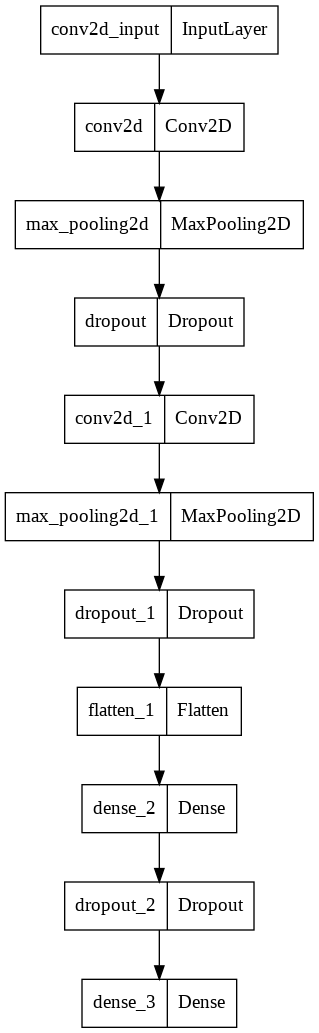

In [29]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='Custome_model_archietecture.png')

Training Custom Model

In [31]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
start_time = time.time()
H = model2.fit(train_generator, batch_size=128,
              epochs=5, 
              validation_data=validation_generator)
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/5
131/131 [==============================] - 100s 758ms/step - loss: 0.4423 - accuracy: 0.8056 - val_loss: 0.4466 - val_accuracy: 0.7962
Epoch 2/5
131/131 [==============================] - 96s 735ms/step - loss: 0.3011 - accuracy: 0.8725 - val_loss: 0.3832 - val_accuracy: 0.8440
Epoch 3/5
131/131 [==============================] - 96s 736ms/step - loss: 0.2766 - accuracy: 0.8854 - val_loss: 0.3191 - val_accuracy: 0.8699
Epoch 4/5
131/131 [==============================] - 95s 725ms/step - loss: 0.2555 - accuracy: 0.8975 - val_loss: 0.3568 - val_accuracy: 0.8392
Epoch 5/5
131/131 [==============================] - 95s 726ms/step - loss: 0.2396 - accuracy: 0.9026 - val_loss: 0.3252 - val_accuracy: 0.8612
--- 483.31268286705017 seconds ---


Testing Custom Model

In [32]:
score = model2.evaluate(test_generator)
print(score)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

20/20 [==============================] - 7s 366ms/step - loss: 0.6366 - accuracy: 0.7324
[0.636589527130127, 0.7323718070983887]
Test Loss =  0.636589527130127
Test Accuracy =  0.7323718070983887


In [33]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# # Predict the values from the validation dataset

# loss, accuracy = model2.evaluate_generator(test_generator)
# print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
# y_pred =  model.predict_generator(test_generator)
# y_p = np.where(y_pred > 0.5, 1,0)
# test_data=test_generator.unbatch()
# y_g=[]
# for image, label in  test_data:
#   y_g.append(label.numpy())

# confusion_mtx = confusion_matrix(y_g, y_p) 
# # plot the confusion matrix
# f,ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

In [34]:
# save the model to disk
import joblib
filename = 'finalized_model2.sav'
joblib.dump(model2, filename)

INFO:tensorflow:Assets written to: ram://b080de79-22a1-4705-91e9-f30a4a420293/assets


['finalized_model2.sav']

Training and Validation Accuracy for Custom Model

In [ ]:
acc=H.history['accuracy']
val_acc=H.history['val_accuracy']
loss=H.history['loss']
val_loss=H.history['val_loss']
 
epochs=range(len(acc)) 
 
#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Accuracy for Custom Model (LR=0.001)')
plt.xlabel('epoch')
plt.savefig("Training and Validation Accuracy ( Custom Model , LR =0.001) Chest.svg")

Training and Validation Loss for Custom Model

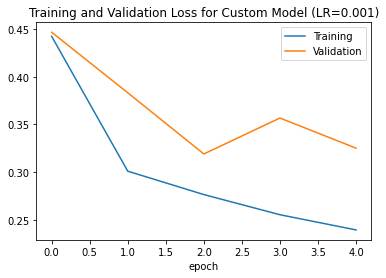

In [37]:

# Plot graph between training and validation loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Loss for Custom Model (LR=0.001)')
plt.xlabel('epoch')
plt.savefig("Training and Validation Loss ( Custom Model , LR =0.001) Chest.svg")

Original Class: 0 - Normal
Predicted Class: 1 - Pneumonia


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


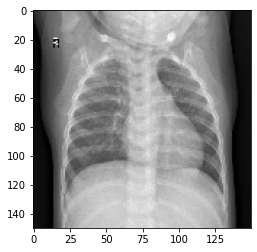

In [40]:
from keras.preprocessing import image
img = image.load_img("/content/chest_xray/train/NORMAL/IM-0122-0001.jpeg",target_size=(150,150))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
print("Original Class: 0 - Normal")
output = model2.predict(img)
x=np.argmax(output, axis=1 )
if x=="0":
    print("Predicted Class: 0 - normal")
else:
    print('Predicted Class: 1 - Pneumonia')

#**Grad-CAM**
https://keras.io/examples/vision/grad_cam/

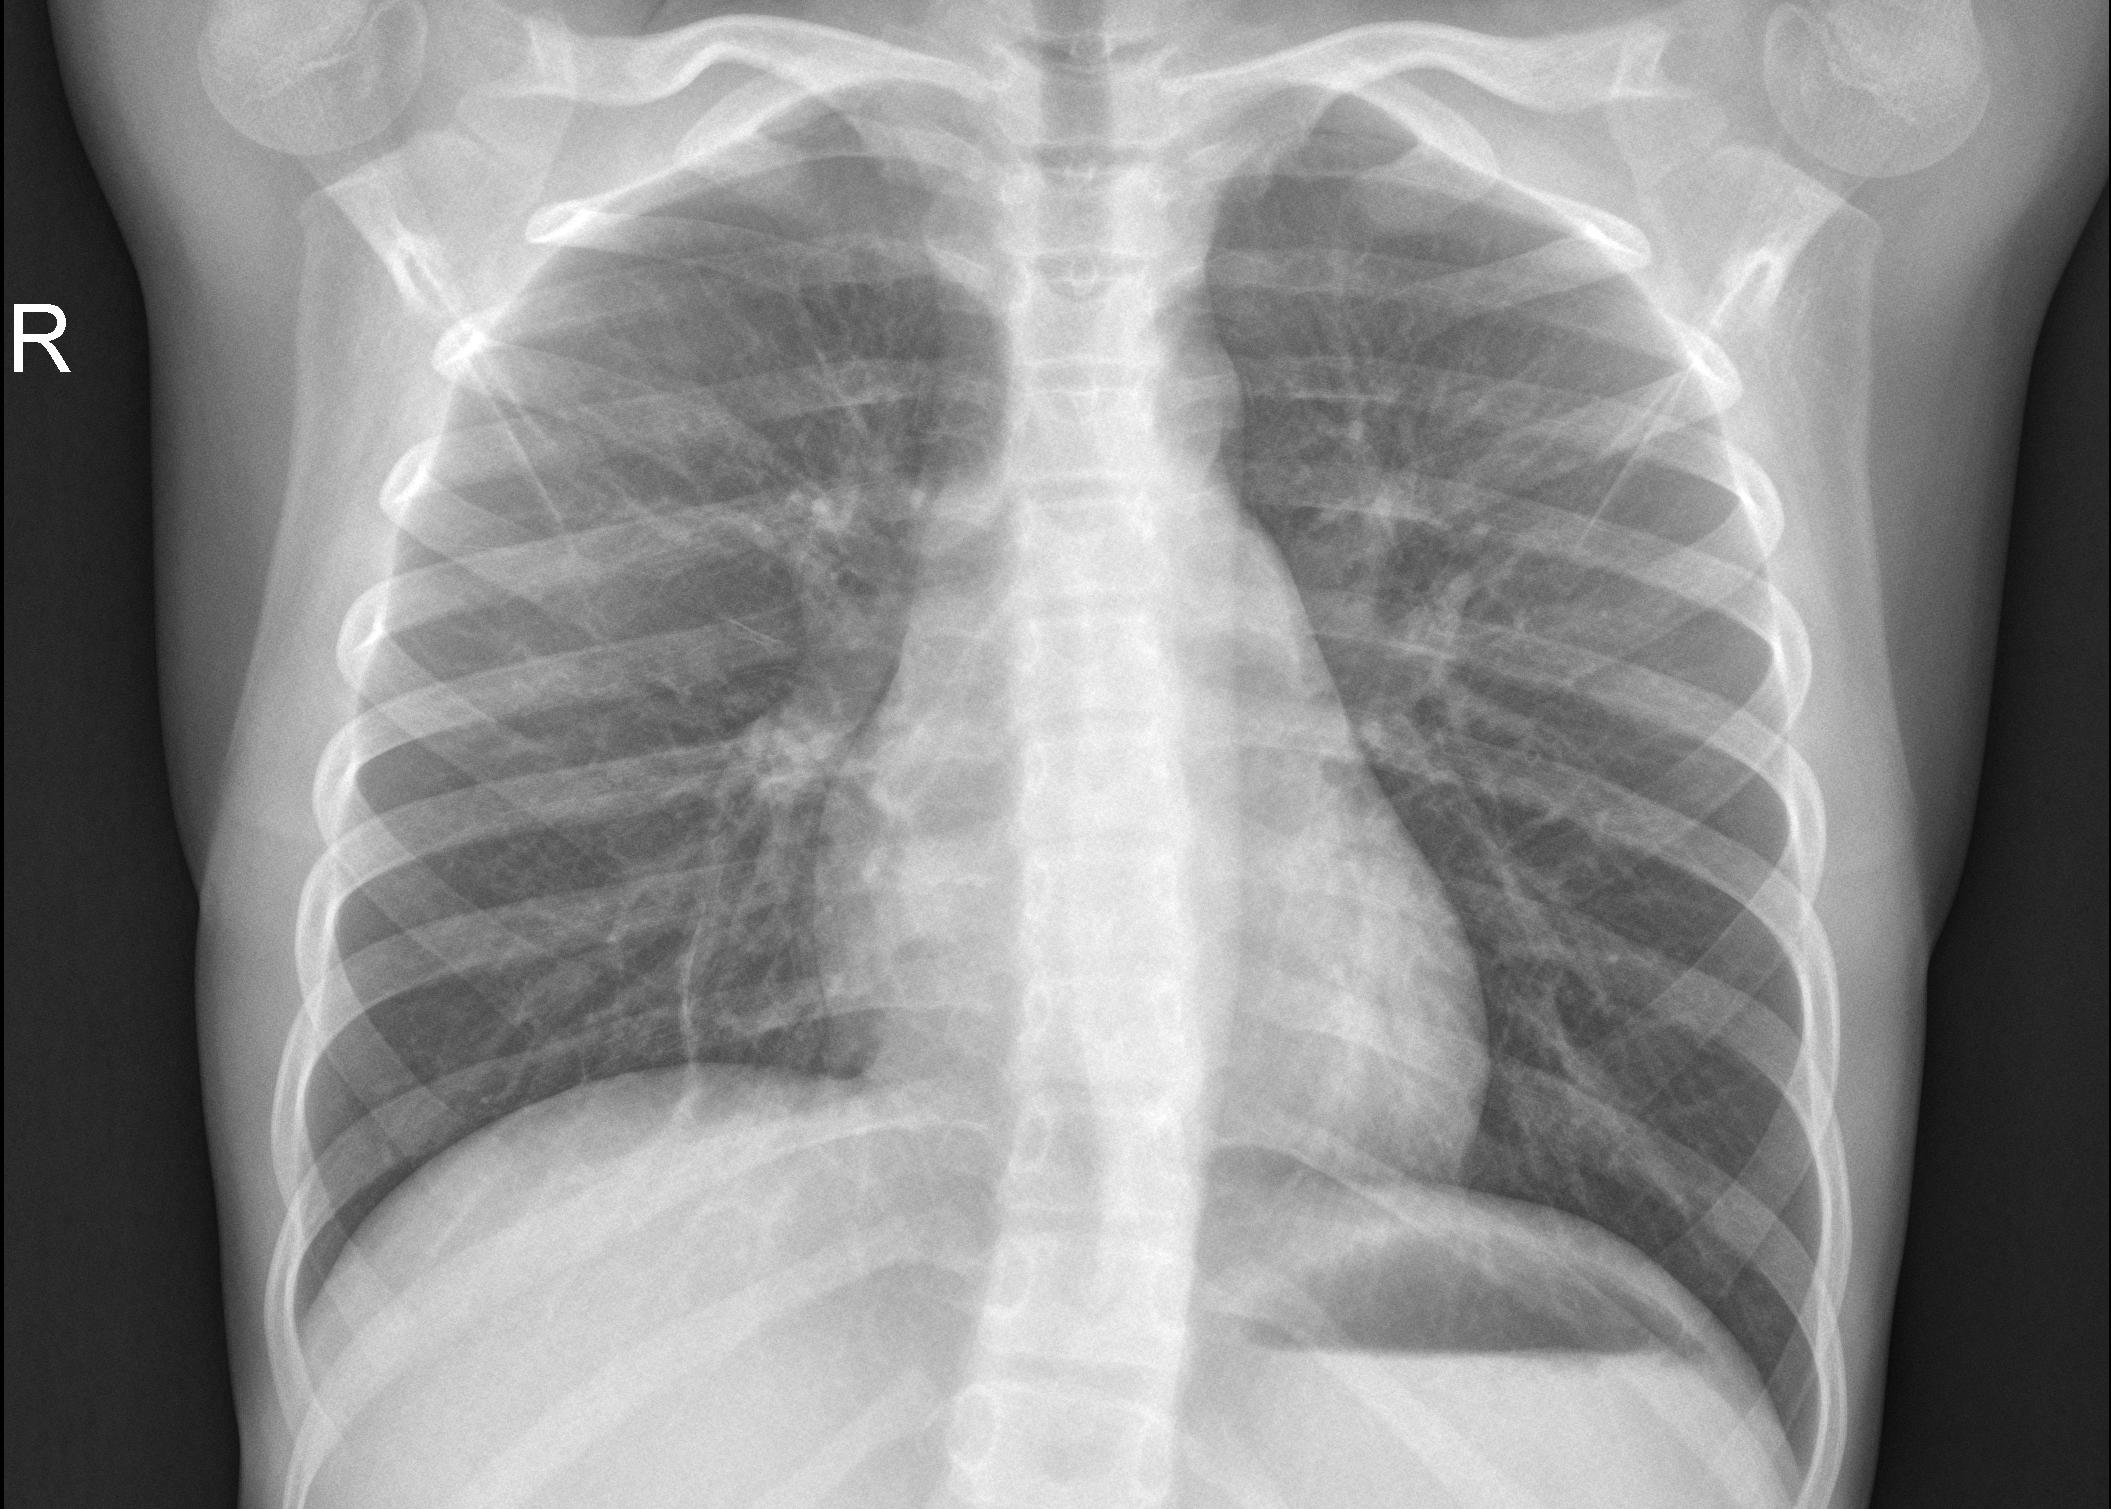

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = model
img_size = (150, 150)
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path = "/content/chest_xray/test/NORMAL/IM-0003-0001.jpeg"

display(Image(img_path))


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

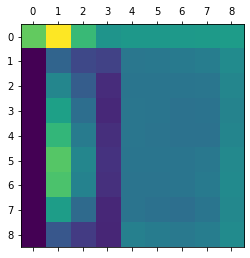

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# # Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


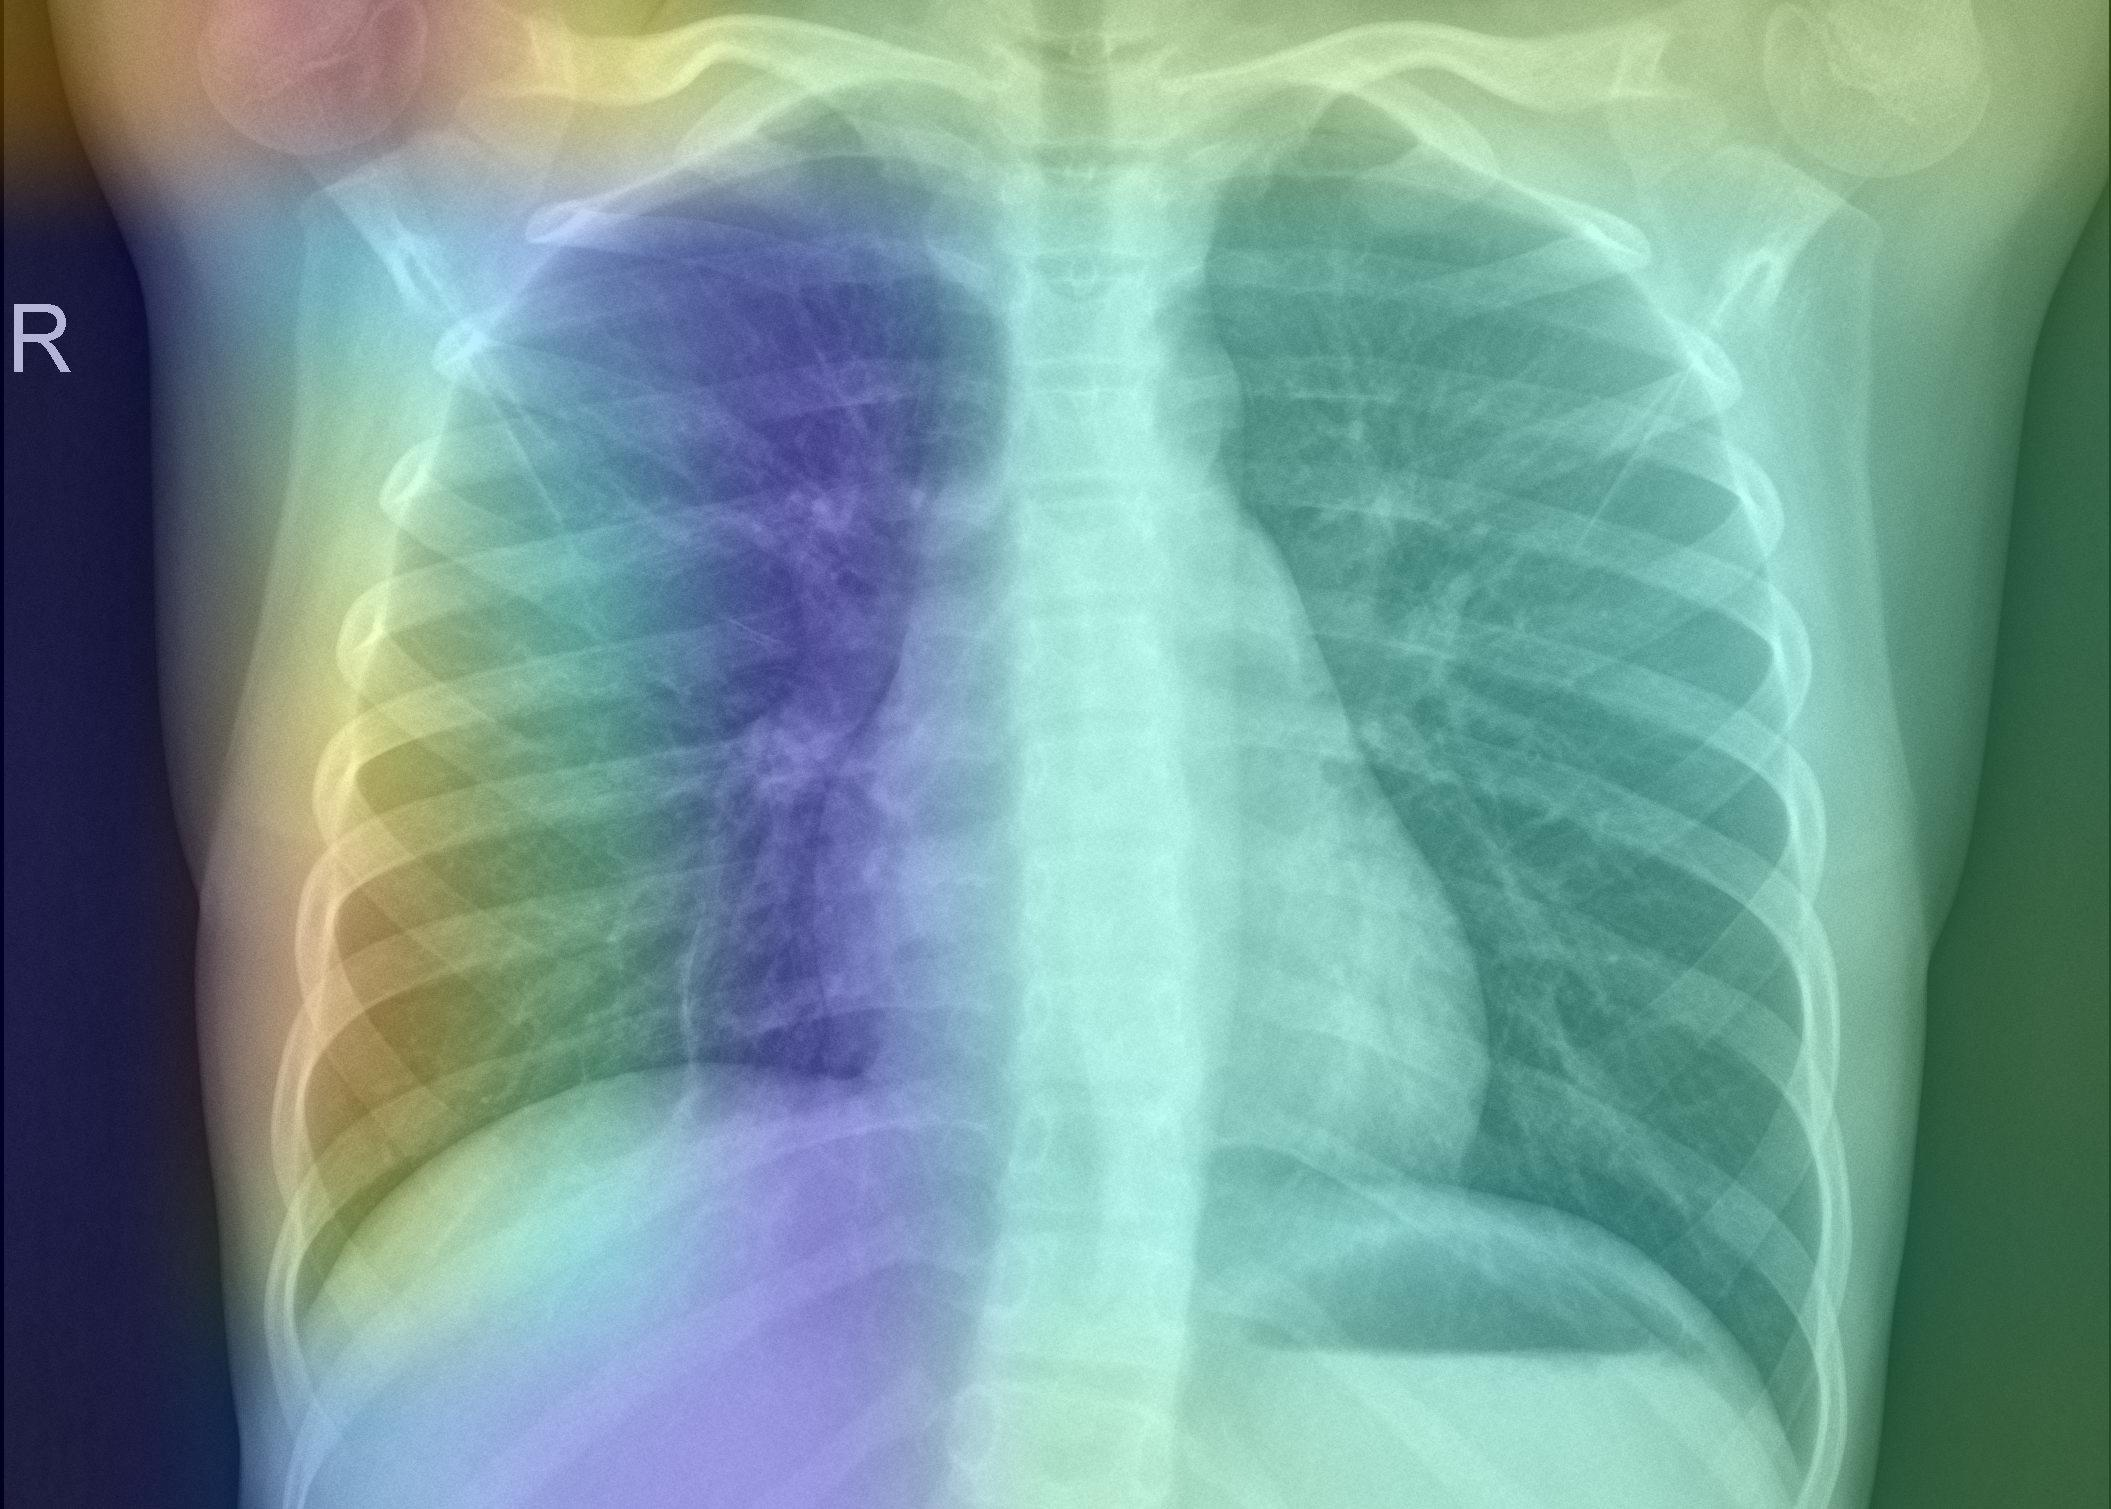

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)